<small><i>This notebook was put together by [Wesley Beckner](http://wesleybeckner.github.io/).</i></small>

In [1]:
import numpy as np
import scipy.io
import scipy.optimize
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import pandas
#import magni
import math
from PIL import Image
#import seaborn as sns; sns.set()

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))
params = {
    'lines.markersize' : 3,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 10,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'text.usetex': False,
    
   }


#plp.rcParams.update(params)
plt.rcParams.update(params)
%matplotlib inline

# Supervised Learning: Random Forests

We would like to use **Random Forests**, a kind of non-parametric supervised learning algorithm, to predict the photoluminesence of a material given some AFM data

## Load and Visualize Data

use the [`numpy.loadtxt`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) function to read in the data from local CSVs
<a id='top'></a>

direct load small multiples [here](#small multiples)

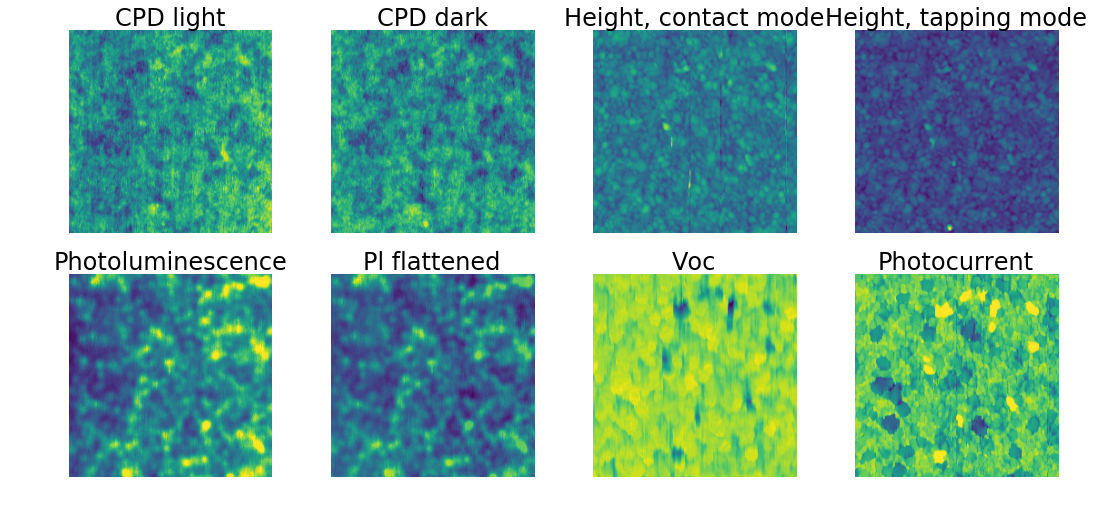

In [21]:
Ht2 = np.loadtxt('MAPI.CPD_dark.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('MAPI.CPD_light.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('MAPI.Photocurrent.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('MAPI.Pl_flattened.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('MAPI.Pl.txt',skiprows=0, dtype=np.float64)
Vo2 = np.loadtxt('MAPI.Voc.txt',skiprows=0, dtype=np.float64)
Ts2 = np.loadtxt('MAPI.Height_ContactMode.txt',skiprows=0, dtype=np.float64)
Ss2 = np.loadtxt('MAPI.Height_TappingMode.txt',skiprows=0, dtype=np.float64)

fig = plt.figure(figsize=(18,8))
po_ax = fig.add_subplot(241)
sa_ax = fig.add_subplot(242)
vo_ax = fig.add_subplot(243)
sd_ax = fig.add_subplot(244)

pl_ax = fig.add_subplot(245)
am_ax = fig.add_subplot(246)
ht_ax = fig.add_subplot(247)
ph_ax = fig.add_subplot(248)


ht_ax.imshow(Vo2, cmap='viridis')#cmap='afmhot'
ht_ax.set_title('Voc', fontsize=24)
ht_ax.axis('off')

po_ax.imshow(Po2, cmap='viridis')#, cmap='cubehelix'
po_ax.set_title('CPD light', fontsize=24)
po_ax.axis('off')

ph_ax.imshow(Ph2, cmap='viridis')
ph_ax.set_title('Photocurrent', fontsize=24)
ph_ax.axis('off')

am_ax.imshow(Am2, cmap='viridis')
am_ax.set_title('Pl flattened', fontsize=24)
am_ax.axis('off')

pl_ax.imshow(Pl2, cmap='viridis')
pl_ax.set_title('Photoluminescence', fontsize=24)
pl_ax.axis('off')

vo_ax.imshow(Ts2, cmap='viridis')#cmap='afmhot'
vo_ax.set_title('Height, contact mode', fontsize=24)
vo_ax.axis('off')

sd_ax.imshow(Ss2, cmap='viridis')#cmap='afmhot'
sd_ax.set_title('Height, tapping mode', fontsize=24)
sd_ax.axis('off')

sa_ax.imshow(Ht2, cmap='viridis')#cmap='afmhot'
sa_ax.set_title('CPD dark', fontsize=24)
sa_ax.axis('off')

plt.show()
fig.savefig(filename='MAPI.jpeg', bbox_inches='tight', format='jpeg') 

# Direct Small Multiple Load

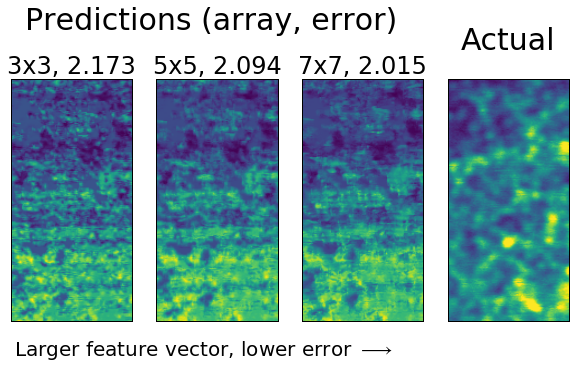

In [19]:
###User specified parameters
inputs = [Ht2, Po2, Ph2, Am2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]
scores = [2.173, 2.094, 2.015]

stuff = [x3x3, x5x5, x7x7]
morestuff = ['3x3', '5x5', '7x7']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

fig = plt.figure(figsize=(10,10))

for wes in range(3):
    pixelContext = stuff[wes]

    Pl_predict = np.load('%s_MAPI.npy' %(morestuff[wes]))
    
    if wes == 2:
        pl_ax.text(-120,-45,'Predictions (array, error)', size=30)#.set_position([.5, 1.2])
        pl_ax.text(-130,250, 'Larger feature vector, lower error $\longrightarrow$', size=20)
    pl_ax = fig.add_subplot(1,4,(wes+1))

    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.set_title('%s Feature Vector, score: %s' %(morestuff[wes],scores[wes]), size=24)
    #pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
    #pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('%s, %s' %(morestuff[wes],scores[wes]), size=24)
pl_ax2 = fig.add_subplot(1,4,4)

pl_ax2.set_title('Actual', size=30).set_position([.5, 1.1])
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:].T, cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                    wspace=None, hspace=None)
fig.savefig(filename='vector_variation_MAPI', bbox_inches='tight')

2.327
2.221
2.141


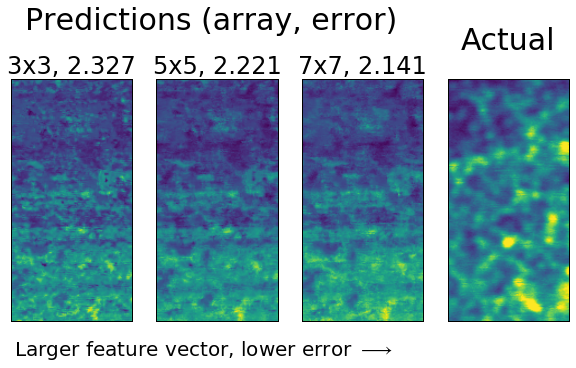

In [20]:
###User specified parameters
Ht2 = np.loadtxt('MAPI.CPD_dark.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('MAPI.CPD_light.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('MAPI.Photocurrent.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('MAPI.Pl_flattened.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('MAPI.Pl.txt',skiprows=0, dtype=np.float64)
Vo2 = np.loadtxt('MAPI.Voc.txt',skiprows=0, dtype=np.float64)
Ts2 = np.loadtxt('MAPI.Height_ContactMode.txt',skiprows=0, dtype=np.float64)
Ss2 = np.loadtxt('MAPI.Height_TappingMode.txt',skiprows=0, dtype=np.float64)


inputs = [Ss2, Vo2, Ph2, Ts2, Ht2, Po2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]

scores = [2.173, 2.094, 2.015]
stuff = [x3x3, x5x5, x7x7]
morestuff = ['3x3', '5x5', '7x7']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

fig = plt.figure(figsize=(10,10))

for wes in range(3):
    pixelContext = stuff[wes]
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0

    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl2[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl2[p,q]
            k = k + 1

    ###Run Algorithm
    k=0
    prediction = []
    q=10
    n=50

    clf = RandomForestRegressor(max_depth=q, n_estimators=n, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)
    print(roundscore)
    prediction.append(hold)
    k = k + 1

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*trees,(y-(max(pixelContext)*2))*depths))
    for l in range(depths):
        for i in range((x-max(pixelContext))*trees):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    np.save('%s_MAPI' %(morestuff[wes]),Pl_predict)
    
    if wes == 2:
        pl_ax.text(-120,-45,'Predictions (array, error)', size=30)#.set_position([.5, 1.2])
        pl_ax.text(-130,250, 'Larger feature vector, lower error $\longrightarrow$', size=20)
    pl_ax = fig.add_subplot(1,4,(wes+1))

    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.set_title('%s Feature Vector, score: %s' %(morestuff[wes],scores[wes]), size=24)
    #pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
    #pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('%s, %s' %(morestuff[wes],roundscore), size=24)
pl_ax2 = fig.add_subplot(1,4,4)

pl_ax2.set_title('Actual', size=30).set_position([.5, 1.1])
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:].T, cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                    wspace=None, hspace=None)
fig.savefig(filename='vector_variation_MAPI', bbox_inches='tight')

# Small Multiples
<a id='small multiples'></a>
[back top top](#top)

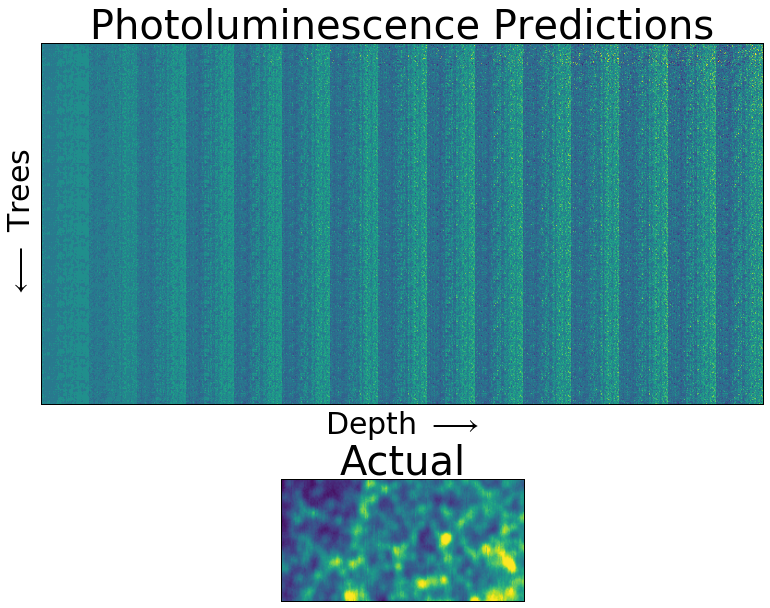

In [22]:
###User specified parameters
Ht2 = np.loadtxt('MAPI.CPD_dark.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('MAPI.CPD_light.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('MAPI.Photocurrent.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('MAPI.Pl_flattened.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('MAPI.Pl.txt',skiprows=0, dtype=np.float64)
Vo2 = np.loadtxt('MAPI.Voc.txt',skiprows=0, dtype=np.float64)
Ts2 = np.loadtxt('MAPI.Height_ContactMode.txt',skiprows=0, dtype=np.float64)
Ss2 = np.loadtxt('MAPI.Height_TappingMode.txt',skiprows=0, dtype=np.float64)


inputs = [Ss2, Vo2, Ph2, Ts2, Ht2, Po2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]
x1x1 = [0]

scores = [2.173, 2.094, 2.015]
stuff = [x1x1]
morestuff = ['1x1']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]
for wes in range(1):
    pixelContext = stuff[wes]
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0

    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl2[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl2[p,q]
            k = k + 1

    ###Run Algorithm
depths = 15
trees = 15
x = Ht2.shape[0]/2*trees
y = Ht2.shape[1]
k=0
prediction = []
scores = []

for q in range(1,depths+1):
    for r in range(1,trees+1):
        clf = RandomForestRegressor(max_depth=q, n_estimators=r, bootstrap=True)
        clf.fit(Xtrain, Ytrain)
        hold = clf.predict(Xtest)
        scores.append(metrics.mean_squared_error(Ytest, hold))
        prediction.append(hold)
        k = k + 1
    

k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros((x,y*depths))
for l in range(depths):
    for i in range(x):
        for j in range (y):
            Pl_predict[i,j+(l*y)] = merge[k]
            k = k + 1

fig = plt.figure(figsize=(20,10))
pl_ax = fig.add_subplot(3,1,(1,2))
pl_ax.imshow(Pl_predict, cmap='viridis')#seismic
pl_ax.set_title('Photoluminescence Predictions', size=40)
pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])

pl_ax2 = fig.add_subplot(4,1,4)
pl_ax2.set_title('Actual', size=40)
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:], cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])

fig.savefig(filename='afm_depth', bbox_inches='tight')

# Code Graveyard

In [ ]:
# flatten the images
Ht1_flat = Ht1.flatten()
Po1_flat = Po1.flatten()
Ph1_flat = Ph1.flatten()
Am1_flat = Am1.flatten()
Pl1_flat = Pl1.flatten()

In [ ]:
Ht2 = np.loadtxt('MAPI.CPD_dark.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('MAPI.CPD_light.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('MAPI.Photocurrent.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('MAPI.Pl_flattened.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('MAPI.Pl.txt',skiprows=0, dtype=np.float64)
Vo2 = np.loadtxt('MAPI.Voc.txt',skiprows=0, dtype=np.float64)
Ts2 = np.loadtxt('MAPI.Height_ContactMode.txt',skiprows=0, dtype=np.float64)
Ss2 = np.loadtxt('MAPI.Height_TappingMode.txt',skiprows=0, dtype=np.float64)

In [ ]:
# flatten the images
Ht2_flat = Ht2.flatten()
Po2_flat = Po2.flatten()
Ph2_flat = Ph2.flatten()
Am2_flat = Am2.flatten()
Pl2_flat = Pl2.flatten()
Vo2_flat = Vo2.flatten()
Ts2_flat = Ts2.flatten()
Ss2_flat = Ss2.flatten()

In [ ]:
Ht2.shape

## Regression Using Random Forests
We'll use a decision tree estimator in scikit-learn: ``sklearn.ensemble.RandomForestRegressor``

I'll start with the simple case of giving each pixel one feature from each image:

In [ ]:
X = [Ht2_flat, Po2_flat, Ph2_flat, Am2_flat]
X = np.array(X).T
Y = np.array(Pl2_flat).T
print(X.shape)
print(Y.shape)
Y

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, random_state=0)
clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

In [ ]:
metrics.mean_squared_error(ytest, ypred)

Let's do this again with a single set of data, splitting the testing and training data halfway down the images.

In [ ]:
Xtrain = np.array([Ht2_flat[0:31625], Po2_flat[0:31625], Ph2_flat[0:31625], Am2_flat[0:31625]]).T
Xtest = np.array([Ht2_flat[31625:], Po2_flat[31625:], Ph2_flat[31625:], Am2_flat[31625:]]).T
Ytrain = np.array(Pl2_flat[0:31625])
Ytest = np.array(Pl2_flat[31625:])
clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, Ypred))

In [ ]:
x = Ht.shape[0]
y = Ht.shape[1]
k=0
merge = np.concatenate((Ytrain,Ypred))
Pl_predict = np.zeros((x,y))
for i in range(x):
    for j in range (y):
        Pl_predict[i,j] = merge[k]
        k = k + 1

Let's see how this looks...

(-0.5, 252.5, 249.5, -0.5)

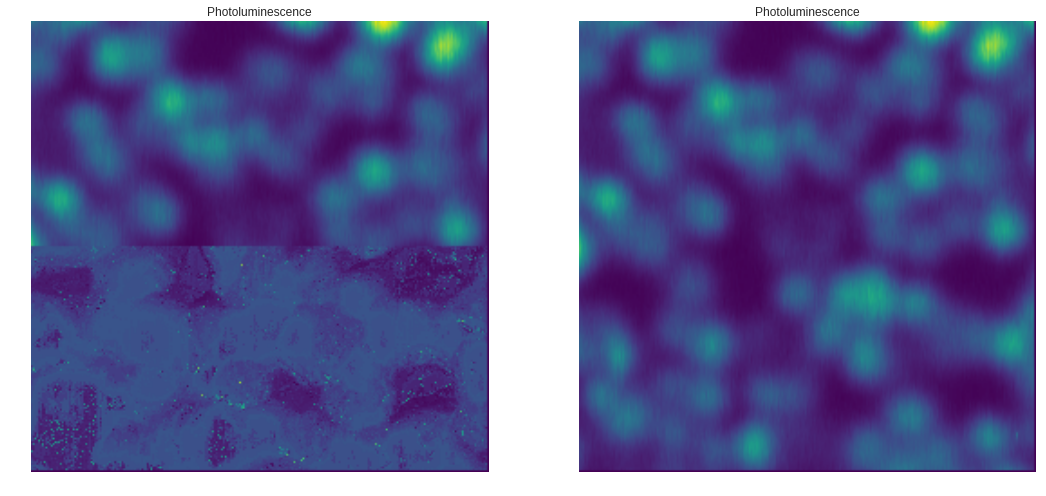

In [20]:
fig = plt.figure(figsize=(18,12))
pl_ax = fig.add_subplot(121)
pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')
pl_ax = fig.add_subplot(122)
pl_ax.imshow(Pl, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

In [27]:
Xtest = np.array([Ht1_flat, Po1_flat, Ph1_flat, Am1_flat]).T
Ytest = np.array([Pl1_flat]).T
Ypred = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, Ypred))

310366227.105


In [21]:
x = Ht.shape[0]
y = Ht.shape[1]
k=0
merge = np.concatenate((Ytrain,Ypred))
Pl_predict = np.zeros((x,y))
for i in range(x):
    for j in range (y):
        Pl_predict[i,j] = merge[k]
        k = k + 1

(-0.5, 252.5, 249.5, -0.5)

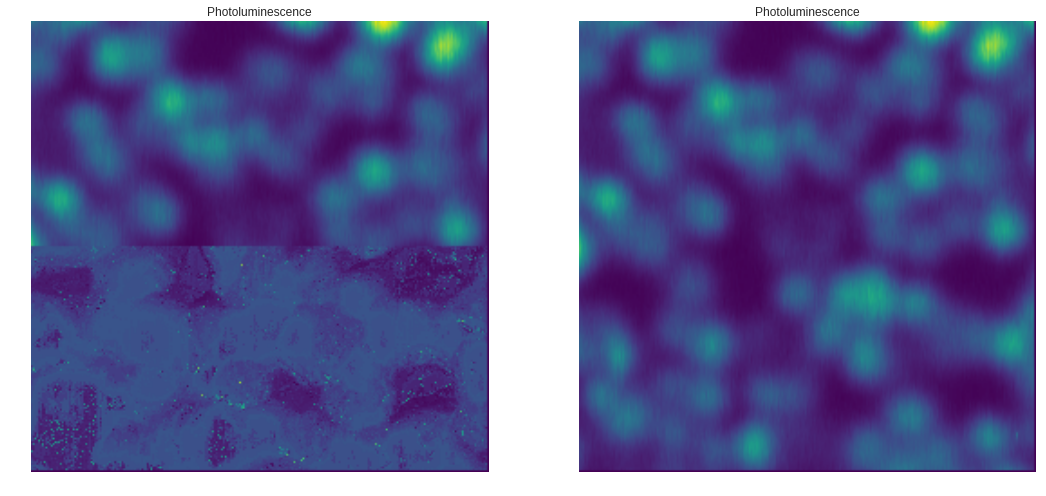

In [20]:
fig = plt.figure(figsize=(18,12))
pl_ax = fig.add_subplot(121)
pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')
pl_ax = fig.add_subplot(122)
pl_ax.imshow(Pl, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

#Scratch Code

Pearson Coefficent = -0.543


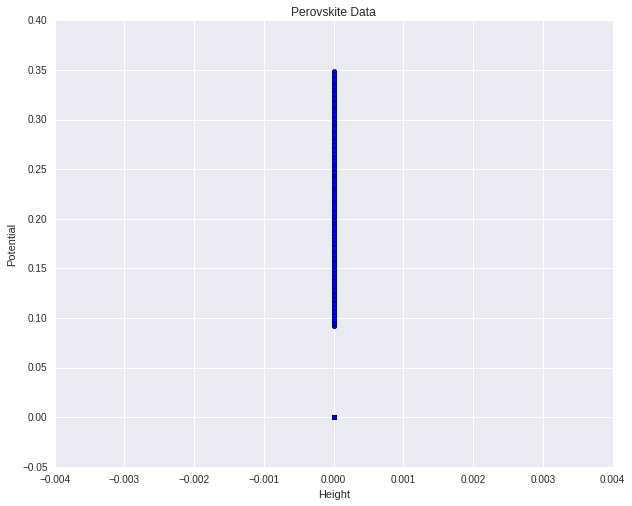

In [9]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr




pearson_coefficient = pearsonr(Ht_flat, Po_flat)
print 'Pearson Coefficent = {:.3f}'.format(pearson_coefficient[0])

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

ax.scatter(Ht_flat, Po_flat)
ax.set_title('Perovskite Data')
ax.set_xlabel('Height')
ax.set_ylabel('Potential')

plt.show()

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:987: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data eithe

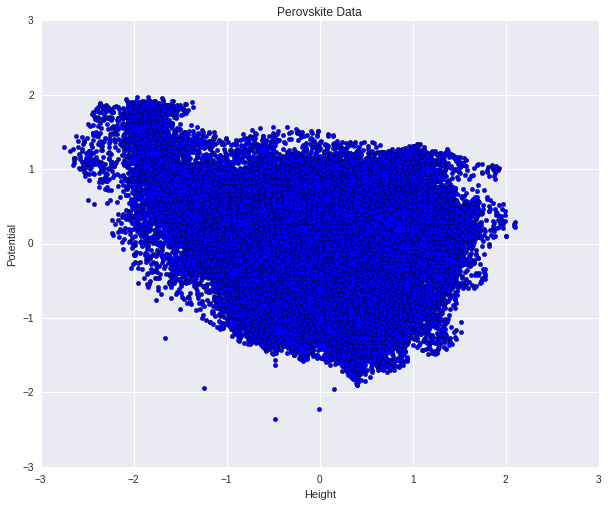

In [33]:
from sklearn import preprocessing

height_flat_norm = preprocessing.robust_scale(Ht1_flat)
potential_flat_norm = preprocessing.robust_scale(Po1_flat)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

ax.scatter(height_flat_norm, potential_flat_norm)
ax.set_title('Perovskite Data')
ax.set_xlabel('Height')
ax.set_ylabel('Potential')

plt.show()

In [1]:
#!/usr/bin/python
#
# Meg Drouhard
# Hierarchical Agglomerative Clustering (HAC) with SciPy for CEI data
# 2/2016

import numpy as np
import scipy.cluster.hierarchy as hac
import scipy.spatial.distance as dist
import pylab
import argparse
import sys



def buildLinkageMatrix(dataMatrix, distanceMeasure):
	# calculate distance 
	distanceMatrix = dist.pdist(dataMatrix, distanceMeasure)
	distanceSquareMatrix = dist.squareform(distanceMatrix)
	linkageMatrix = hac.linkage(distanceSquareMatrix)
	return linkageMatrix

def saveDendrogram(linkageMatrix, label):
	dendrogramName = 'Dendrogram-' + label + '.png'

	# Create and save dendrogram image
	dataDendrogram = hac.dendrogram(linkageMatrix)
	pylab.savefig(dendrogramName)

def printStats(linkageMatrix):
	# Calculate cluster statistics
	copheneticMatrix = hac.cophenet(linkageMatrix)
	copheneticMedian = np.median(copheneticMatrix)
	inconsistencyMatrix = hac.inconsistent(linkageMatrix)
	maxInconsistencyMatrix = hac.maxinconsts(linkageMatrix, inconsistencyMatrix)
	maxInconsistencyMedian = np.median(maxInconsistencyMatrix)
	maxdistsMatrix = hac.maxdists(linkageMatrix)
	maxdistsMedian = np.median(maxdistsMatrix)

	# print stats
	#Cophenetic distance = intergroup dissimilarity
	print "Median Cophenetic distance: " + str(copheneticMedian)
	print "Median Maximum Inconsistency: " + str(maxInconsistencyMedian)
	print "Median MaxDist: " + str(maxdistsMedian)


###############################################################################

# Parse arguments
parser = argparse.ArgumentParser(description='Cluster weighted text hierarchically.')

parser.add_argument('-i',
                        '--input-file',
                        dest='inputfile',
                        required=True,
                        help='input file name')

parser.add_argument('-l',
                        '--label',
                        dest='inputlabel',
                        required=False,
                        help='label for output files')

args = parser.parse_args()

# setup the path argument if provided
if args.inputfile:
    fname = args.inputfile
else:
    sys.exit('Error: missing input file.')

label = ''
if args.inputlabel:
		label = args.inputlabel

with open(fname, 'r') as f:
	# Load data
	data = np.loadtxt(f,skiprows=0)
	# reshape as 256x256 matrix
	dataMatrix = np.reshape(data, (256,256))
	print dataMatrix.shape

	# Plot initial data as image
	pylab.imshow(dataMatrix)
	pylab.show()

	# Build linkage matrices for clustering
	# Euclidean distance
	euclideanLinkageMatrix = buildLinkageMatrix(dataMatrix, 'euclidean')
	# Cosine distance
	cosineLinkageMatrix = buildLinkageMatrix(dataMatrix, 'cosine')
	# Hamming distance
	hammingLinkageMatrix = buildLinkageMatrix(dataMatrix, 'hamming')
	# Jaccard distance
	jaccardLinkageMatrix = buildLinkageMatrix(dataMatrix, 'jaccard')


	# save dendrograms
	saveDendrogram(euclideanLinkageMatrix, label + '-Euclidean')
	saveDendrogram(cosineLinkageMatrix, label + '-Cosine')
	saveDendrogram(hammingLinkageMatrix, label + '-Hamming')
	saveDendrogram(jaccardLinkageMatrix, label +'-Jaccard')
	

	# Calculate and print cluster statistics
	print "Cluster Statistics:"
	print "Eudclidean Distance:"
	printStats(euclideanLinkageMatrix)
	print ""
	print "Cosine Distance:"
	printStats(cosineLinkageMatrix)
	print ""
	print "Hamming Distance:"
	printStats(hammingLinkageMatrix)
	print ""
	print "Jaccard Distance:"
	printStats(jaccardLinkageMatrix)

SyntaxError: invalid syntax (<ipython-input-1-7f29b42ea9ef>, line 42)